In [1]:
import numpy as np
from numpy import convolve
import matplotlib.pyplot as plt
 
def movingaverage(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [2]:
def moving_fun(dataframe, col, blanking, duration, newname='movmin', fun=min):
    """blanking: # timepoints between 'now' and evaluation. duration: # timepoints to evaluate"""
    dataframe[newname] = np.nan
    colidx = list(dataframe.columns).index(col)
    newnameidx = list(dataframe.columns).index(newname)
    datalen = len(dataframe)
    dataframe.iloc[blanking+duration:, newnameidx] = np.fromiter((fun(dataframe.iloc[idx:idx+duration, colidx])
                                                     for idx in range(datalen-blanking-duration)),
                                                     dtype=np.float64)

In [3]:
def percent_change(dataframe, col, newname='percent_change'):
    dataframe[newname] = 0
    newidx = list(dataframe.columns).index(newname)
    colidx = list(dataframe.columns).index(col)
    idcs_all = list(dataframe.index)
    dataframe.iloc[idcs_all[1:], newidx] = ((dataframe.iloc[idcs_all[1:], colidx].values -
                                              dataframe.iloc[idcs_all[:-1], colidx].values) /
                                             dataframe.iloc[idcs_all[1:], colidx].values)

def diff(dataframe, col, newname='percent_change'):
    dataframe[newname] = 0
    newidx = list(dataframe.columns).index(newname)
    colidx = list(dataframe.columns).index(col)
    idcs_all = list(dataframe.index)
    dataframe.iloc[idcs_all[1:], newidx] = (dataframe.iloc[idcs_all[1:], colidx].values -
                                            dataframe.iloc[idcs_all[:-1], colidx].values)


In [4]:
# import & export csv
import csv
def save_data(array, name):
    np.savetxt(name, array, delimiter=',')

def load_data(name):
    return np.genfromtxt(name, delimiter=',')

def split_data(array, nrpartitions=3):
    bunchsize = int(len(array)/nrpartitions)
    return [array[i*bunchsize:(i+1)*bunchsize, :] for i in range(nrpartitions)]

In [5]:
import pandas as pd
def pandize_data(data):
    # sort
    idx = np.argsort(data[:, 0])
    data = data[idx, :]
    # fill missing time points with NaN.
    deltats = data[1:, 0] - data[:-1, 0]
    deltat = min(deltats)
    gaps = np.argwhere(deltats > deltat)
    inserted = 0
    for gap in gaps:
        gap = gap[0] + inserted
        addlines = np.arange(start=data[gap, 0]+deltat, stop=data[gap+1, 0], step=deltat)
        adddata = np.ones((len(addlines), data.shape[1])) * np.nan
        adddata[:, 0] = addlines
        inserted = inserted + len(addlines)
        data = np.vstack((data[:gap+1, :], adddata, data[gap+1:, :]))
    cols = ['time', 'open', 'highest', 'lowest', 'closing', 'volume']
    df = pd.DataFrame(data=data, columns=cols)
    return df

In [6]:
def strat_minmax_measure(dataframe, smaperiod, minmaxperiod):
    """measure things on dataframe
    smaperiod
        period in minutes of moving average
    minmaxperiod
        period to calculate the minimum/maximum over, in minutes
    """
    # get deltat in min; time is in ms
    basic_clock = int((dataframe.loc[1, 'time']-dataframe.loc[0, 'time'])/60000)
    tperiod_minmax = int(minmaxperiod / basic_clock)
    tperiod_smalong = int(2*smaperiod / basic_clock)
    tperiod_smashort = int(smaperiod / basic_clock)

    # moving averages of hi and lo prices
    moving_fun(dataframe, 'highest', blanking=0, duration=tperiod_smashort,
               newname='sma-hi-now', fun=np.mean)
    moving_fun(dataframe, 'lowest', blanking=0, duration=tperiod_smashort,
               newname='sma-lo-now', fun=np.mean)
    # moving average of one period previously
    moving_fun(dataframe, 'highest', blanking=tperiod_smashort, duration=tperiod_smashort,
               newname='sma-hi-prev', fun=np.mean)
    moving_fun(dataframe, 'lowest', blanking=tperiod_smashort, duration=tperiod_smashort,
               newname='sma-lo-prev', fun=np.mean)
    
    # moving min and max of hi nd lo prices
    moving_fun(dataframe, 'sma-hi-now', blanking=2*tperiod_smashort, duration=tperiod_minmax,
               newname='min-hi-prev', fun=np.min)
    moving_fun(dataframe, 'sma-lo-now', blanking=2*tperiod_smashort, duration=tperiod_minmax,
               newname='max-lo-prev', fun=np.max)
#     moving_fun(dataframe, 'highest', blanking=tperiod_smashort, duration=tperiod_minmax,
#                newname='min-hi', fun=np.min)
#     moving_fun(dataframe, 'lowest', blanking=tperiod_smashort, duration=tperiod_minmax,
#                newname='max-lo', fun=np.max)
    # quotient of max and min
    dataframe['max/min'] = dataframe['max-lo-prev']/dataframe['min-hi-prev']
    
def strat_minmax_findbuy(dataframe):
    """find time points for buying"""
    dataframe.loc[((dataframe['sma-hi-now'] > dataframe['sma-hi-prev']) &
                   (dataframe['sma-hi-prev'] < dataframe['min-hi-prev'])
                  )
                  , 'buy'] = 1

def strat_minmax_findsell(dataframe):
    """find time points for selling"""
    dataframe.loc[((dataframe['sma-lo-now'] < dataframe['sma-lo-prev']) &
                   (dataframe['sma-lo-prev'] > dataframe['max-lo-prev'])
                  )
                  , 'sell'] = 1

In [7]:
# backtest
def backtest_minmax(dataframe, amount_buy=.05, amount_sell=10, delay=0, minfunds_USD=10, minfunds_BTC=.005):
    """
    Args:
        amount..
            amount of currency to buy or sell for
        delay:
            #rows until order is performed
    """
    cols_required = ['USD', 'dUSD', 'BTC', 'dBTC']
    for colreq in cols_required:
        if colreq not in list(dataframe.columns):
            dataframe[colreq] = 0
#     dataframe.loc[1:, 'USD'] = 0
#     dataframe.loc[1:, 'BTC'] = 0
#     dataframe['dUSD'] = 0
#     dataframe['dBTC'] = 0

    for idx, row in dataframe.iterrows():
        if row['max/min'] > 1.0075:
            if row['buy']==1 and amount_buy>0 and dataframe.loc[idx, 'USD']>minfunds_USD:
                # pessimistic buy for highest price in following minutes
                price = max(dataframe.loc[idx:idx+2, 'highest'])
                # or buy instantly
    #            price = dataframe.loc[idx, 'highest']
                if not np.isnan(price):
                    if price*amount_buy > dataframe.loc[idx, 'USD']:
                        amount_buy_now = dataframe.loc[idx, 'USD'] / price
                    else:
                        amount_buy_now = amount_buy
                    dataframe.loc[idx, 'dUSD'] -= price*amount_buy_now
                    dataframe.loc[idx, 'dBTC'] += amount_buy_now
            if row['sell']==1 and amount_sell>0 and dataframe.loc[idx, 'BTC']>minfunds_BTC:
                # pessimistic buy for lowest price in following minutes
                price = min(dataframe.loc[idx:idx+2, 'lowest'])
                # or sell instantly
    #            price = dataframe.loc[idx, 'lowest']
                if not np.isnan(price):
                    if amount_sell > dataframe.loc[idx, 'BTC']:
                        amount_sell_now = dataframe.loc[idx, 'BTC']
                    else:
                        amount_sell_now = amount_sell
                    dataframe.loc[idx, 'dUSD'] += price*amount_sell_now
                    dataframe.loc[idx, 'dBTC'] -= amount_sell_now
    #             dataframe.loc[idx+1, 'USD'] = dataframe.loc[idx, 'USD'] + dataframe.loc[idx, 'dUSD']
    #             dataframe.loc[idx+1, 'BTC'] = dataframe.loc[idx, 'BTC'] + dataframe.loc[idx, 'dBTC']
        if idx+1 < len(dataframe):
            dataframe.loc[idx+1, 'USD'] += dataframe.loc[idx, 'USD'] + dataframe.loc[idx, 'dUSD']
            dataframe.loc[idx+1, 'BTC'] += dataframe.loc[idx, 'BTC'] + dataframe.loc[idx, 'dBTC']
#     dataframe['USD'] = dataframe.loc[0, 'USD'] + np.cumsum(dataframe['dUSD'])
#     dataframe['BTC'] = dataframe.loc[0, 'BTC'] + np.cumsum(dataframe['dBTC'])  

In [8]:
# strategy based on spread
def strat_spread_measure(dataframe):
    dataframe['spread'] = (dataframe['highest'] - dataframe['lowest'])/dataframe['highest']
    return

def strat_spread_findbuy(dataframe):
    return

def strat_spread_findsell(dataframe):
    return

In [9]:
# strategy based on trend

def sumoversumabs(x):
#     print(x)
#     print(x[1:])
#     print(x[:-1])
    diffx = (x[1:].values-x[:-1].values)/x[1:].values
#     print(diffx)
#     print(np.sum(diffx)/np.sum(np.abs(diffx)))
    return np.mean(diffx)#/np.sum(np.abs(diffx))

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

    
def strat_trend_measure(dataframe, duration=3):
#     moving_fun(dataframe, 'highest', blanking=0, duration=duration, newname='trend_hi', fun=sumoversumabs)
#     moving_fun(dataframe, 'lowest', blanking=0, duration=duration, newname='trend_lo', fun=sumoversumabs)
#     moving_fun(dataframe, 'highest', blanking=0, duration=2*duration, newname='trend_hi*2', fun=sumoversumabs)
#     moving_fun(dataframe, 'lowest', blanking=0, duration=2*duration, newname='trend_lo*2', fun=sumoversumabs)
#     moving_fun(dataframe, 'highest', blanking=0, duration=10*duration, newname='trend_hi*10', fun=sumoversumabs)
#     moving_fun(dataframe, 'lowest', blanking=0, duration=10*duration, newname='trend_lo*10', fun=sumoversumabs)
#    
#     # percent change
#     dataframe['diff-hi'] = 0
#     diffidx = list(dataframe.columns).index('diff-hi')
#     hiidx = list(dataframe.columns).index('highest')
#     idcs_all = list(dataframe.index)
#     dataframe.iloc[idcs_all[1:], diffidx] = ((dataframe.iloc[idcs_all[1:], hiidx].values -
#                                               dataframe.iloc[idcs_all[:-1], hiidx].values) /
#                                              dataframe.iloc[idcs_all[1:], hiidx].values)
#     # bandpass filters
#     dataframe['bandpass_hi_3-10'] = butter_bandpass_filter(dataframe['diff-hi'], 1/10, 1/3, 1, 1)
#     dataframe['bandpass_hi_10-30'] = butter_bandpass_filter(dataframe['diff-hi'], 1/30, 1/10, 1, 1)
    dataframe['bp_hi_3-10'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/10, 1/3, 1, 1)/dataframe['highest']
    moving_fun(dataframe, 'bp_hi_3-10', 0, 3, 'sma_bp_hi_3-10')
    diff(dataframe, 'sma_bp_hi_3-10', 'dsma_bp_hi_3-10')
    dataframe['bp_hi_3-120'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/120, 1/3, 1, 1)/dataframe['highest']
    moving_fun(dataframe, 'bp_hi_3-120', 0, 3, 'sma_bp_hi_3-120')
    diff(dataframe, 'sma_bp_hi_3-120', 'dsma_bp_hi_3-120')
    dataframe['bp_hi_3-2000'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/2000, 1/3, 1, 1)/dataframe['highest']
    dataframe['bp_hi_10-30'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/30, 1/10, 1, 1)/dataframe['highest']
    dataframe['bp_hi_30-120'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/120, 1/30, 1, 1)/dataframe['highest']
    dataframe['bp_hi_500-2000'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/2000, 1/500, 1, 1)/dataframe['highest']
    dataframe['bp_hi_1000-5000'] = butter_bandpass_filter(dataframe['highest']-dataframe.loc[0, 'highest'], 1/5000, 1/1000, 1, 1)/dataframe['highest']

def strat_trend_findbuy(dataframe, colname='bp_hi_3-120', threshold=.01):
    dataframe.loc[((dataframe[colname] > threshold) &
                   (dataframe['dsma_' + colname] > 0)
                  )
                  , 'buy'] = 1

def strat_trend_findsell(dataframe, colname='bp_hi_3-120', threshold=.01):
    dataframe.loc[((dataframe['dsma_' + colname] < 0)
                  )
                  , 'sell'] = 1

# print(sumoversumabs(np.array([3, -3, 2])))

In [10]:
# backtest
def backtest_trend(dataframe, amount_buy=10, amount_sell=10, delay=0, minfunds_USD=10, minfunds_BTC=.005):
    """
    Args:
        amount..
            max amount of cryptocurrency to buy or sell for
        delay:
            #rows until order is performed
    """
    cols_required = ['USD', 'dUSD', 'BTC', 'dBTC']
    for colreq in cols_required:
        if colreq not in list(dataframe.columns):
            dataframe[colreq] = 0
#     dataframe.loc[1:, 'USD'] = 0
#     dataframe.loc[1:, 'BTC'] = 0
#     dataframe['dUSD'] = 0
#     dataframe['dBTC'] = 0

    for idx, row in dataframe.iterrows():
        if row['buy']==1 and amount_buy>0 and dataframe.loc[idx, 'USD']>minfunds_USD:
            # pessimistic buy for highest price in following minutes
            price = max(dataframe.loc[idx:idx+2, 'highest'])
            # or buy instantly
#            price = dataframe.loc[idx, 'highest']
            if not np.isnan(price):
                if price*amount_buy > dataframe.loc[idx, 'USD']:
                    amount_buy_now = dataframe.loc[idx, 'USD'] / price
                else:
                    amount_buy_now = amount_buy
                dataframe.loc[idx, 'dUSD'] -= price*amount_buy_now
                dataframe.loc[idx, 'dBTC'] += amount_buy_now
        if row['sell']==1 and amount_sell>0 and dataframe.loc[idx, 'BTC']>minfunds_BTC:
            # pessimistic buy for lowest price in following minutes
            price = min(dataframe.loc[idx:idx+2, 'lowest'])
            # or sell instantly
#            price = dataframe.loc[idx, 'lowest']
            if not np.isnan(price):
                if amount_sell > dataframe.loc[idx, 'BTC']:
                    amount_sell_now = dataframe.loc[idx, 'BTC']
                else:
                    amount_sell_now = amount_sell
                dataframe.loc[idx, 'dUSD'] += price*amount_sell_now
                dataframe.loc[idx, 'dBTC'] -= amount_sell_now
        if idx+1 < len(dataframe):
            dataframe.loc[idx+1, 'USD'] += dataframe.loc[idx, 'USD'] + dataframe.loc[idx, 'dUSD']
            dataframe.loc[idx+1, 'BTC'] += dataframe.loc[idx, 'BTC'] + dataframe.loc[idx, 'dBTC']


In [11]:
def diagnose(dataframe):
    dataframe['tot_USD'] = dataframe['USD'] + dataframe['BTC']*dataframe['lowest']
    minprice = min(dataframe['lowest'])
    dataframe['tot_USD_cons'] = dataframe['USD'] + dataframe['BTC']*minprice
    dataframe['tot_BTC'] = dataframe['BTC'] + dataframe['USD']/dataframe['highest']
    results = {}
    results['investment'] = dataframe.loc[0, 'tot_USD']  # - min(dataframe['tot_USD'])
    results['return_on_inv_perc'] = (dataframe.loc[len(dataframe)-1, 'tot_USD']/results['investment']-1)*100
    dataframe['return_on_inv_perc'] = (dataframe['tot_USD']/results['investment']-1)*100
    dt_days = (dataframe.loc[len(dataframe)-1, 'time'] - dataframe.loc[0, 'time'])/1000/3600/24
    results['roi_per_day'] = ((results['return_on_inv_perc']/100+1)**(1/dt_days)-1)*100
    results['nrbuys'] = dataframe['buy'].sum(skipna=True)
    results['nrsells'] = dataframe['sell'].sum(skipna=True)
    results['transactions'] = (dataframe['dUSD']!=0).sum()
    buy_hold_perc = 100*(dataframe.loc[len(dataframe)-1, 'highest'] /
                         dataframe.loc[0, 'highest']-1)
    buy_hold_per_day = ((buy_hold_perc/100+1)**(1/dt_days)-1)*100
    results['buy_hold'] = buy_hold_perc
    results['vs_buy_hold'] = results['return_on_inv_perc'] - buy_hold_perc
    results['vs_buy_hold_per_day'] = results['roi_per_day'] - buy_hold_per_day
    return results

Index(['time', 'open', 'highest', 'lowest', 'closing', 'volume', 'bp_hi_3-10',
       'sma_bp_hi_3-10', 'dsma_bp_hi_3-10', 'bp_hi_3-120', 'sma_bp_hi_3-120',
       'dsma_bp_hi_3-120', 'bp_hi_3-2000', 'bp_hi_10-30', 'bp_hi_30-120',
       'bp_hi_500-2000', 'bp_hi_1000-5000', 'buy', 'sell', 'USD', 'BTC',
       'dUSD', 'dBTC', 'tot_USD', 'tot_USD_cons', 'tot_BTC',
       'return_on_inv_perc'],
      dtype='object')


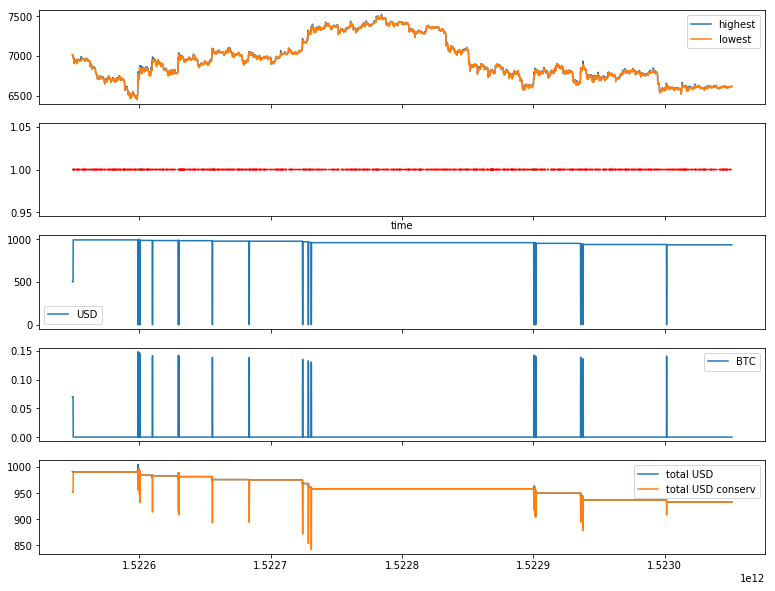

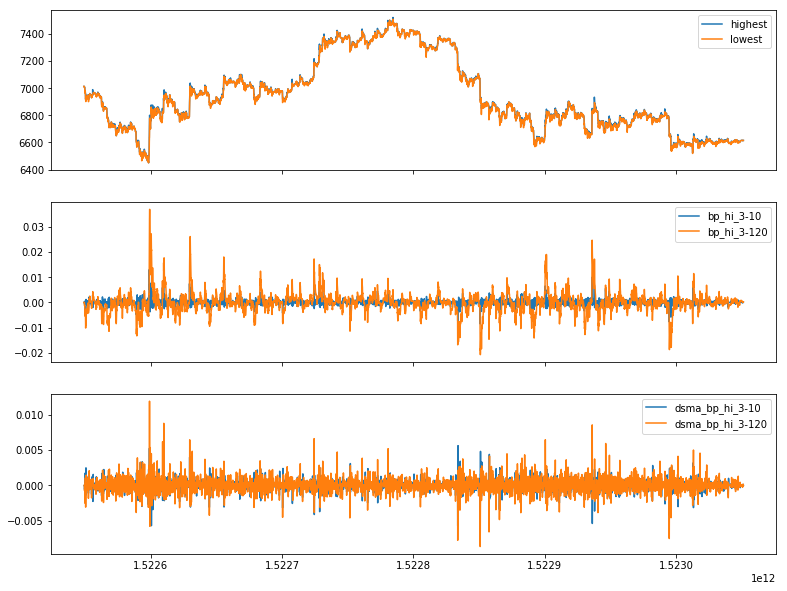

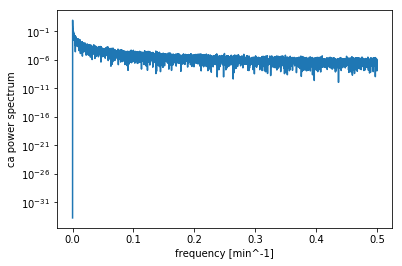

--------------------
end balance: 932.63 USD + 0.00000 BTC which equates 932.63 USD or 0.14099 BTC
further results
{'investment': 990.8764000000001, 'return_on_inv_perc': -5.878668465309422, 'roi_per_day': -1.0376572815705143, 'nrbuys': 62.0, 'nrsells': 3120.0, 'transactions': 35, 'buy_hold': -5.669137957342074, 'vs_buy_hold': -0.20953050796734818, 'vs_buy_hold_per_day': -0.03789464264113418}


In [12]:
# plot performance

# enablo zooming into fig
%matplotlib inline
import mpld3
mpld3.enable_notebook()

data = load_data('gdax_data.csv')
df = pandize_data(data)
# strat_minmax_measure(df, smaperiod=10, minmaxperiod=60)
strat_trend_measure(df, duration=20)
# strat_spread_measure(df)

# strat_minmax_findbuy(df)
# strat_minmax_findsell(df)
strat_trend_findbuy(df, colname='bp_hi_3-120', threshold=.01)
strat_trend_findsell(df, colname='bp_hi_3-120', threshold=.01)

df['USD'] = 0
df.loc[0, 'USD'] = 500
df['BTC'] = 0
df.loc[0, 'BTC'] = .07
backtest_trend(df, amount_buy=5, amount_sell=5)
results = diagnose(df)

print(df.columns)
# print(df)
# fig = plt.gcf()
# ax = plt.gca()

fig, ax = plt.subplots(nrows=5, sharex=True)
ax[0].plot(df['time'], df['highest'], label='highest')
ax[0].plot(df['time'], df['lowest'], label='lowest')
ax[0].legend()
# axr = ax.twinx()
ax[1].plot(df['time'], df['buy'], color='g')
ax[1].plot(df['time'], df['sell'], color='r')
ax[1].set_xlabel('time')

ax[2].plot(df['time'], df['USD'], label='USD')
ax[2].legend()
# ax2r = ax[2].twinx()
# ax2r.plot(df['time'], df['BTC'], label='BTC')
ax[3].plot(df['time'], df['BTC'], label='BTC')
ax[3].legend()
# ax[2].legend()
ax[4].plot(df['time'], df['tot_USD'], label='total USD')
ax[4].plot(df['time'], df['tot_USD_cons'], label='total USD conserv')
ax[4].legend()

# plt.xlabel('time')
# plt.legend()
fig.set_size_inches(13, 10)

fig2, ax2 = plt.subplots(nrows=3, sharex=True)
ax2[0].plot(df['time'], df['highest'], label='highest')
ax2[0].plot(df['time'], df['lowest'], label='lowest')
ax2[0].legend()
ax2[1].plot(df['time'], df['bp_hi_3-10'], label='bp_hi_3-10')
ax2[1].plot(df['time'], df['bp_hi_3-120'], label='bp_hi_3-120')
# ax2[1].plot(df['time'], df['bp_hi_3-2000'], label='bp_hi_3-2000')
# ax2[1].plot(df['time'], df['bp_hi_10-30'], label='bp_hi_10-30')
# ax2[1].plot(df['time'], df['bp_hi_30-120'], label='bp_hi_30-120')
# ax2[1].plot(df['time'], df['bp_hi_500-2000'], label='bp_hi_500-2000')
ax2[1].legend()
ax2[2].plot(df['time'], df['dsma_bp_hi_3-10'], label='dsma_bp_hi_3-10')
ax2[2].plot(df['time'], df['dsma_bp_hi_3-120'], label='dsma_bp_hi_3-120')
ax2[2].legend()
fig2.set_size_inches(13, 10)

from scipy.signal import periodogram
fs, Pxx = periodogram((df['highest'].values-np.mean(df['highest'].values))/np.mean(df['highest'].values))
fig3, ax3 = plt.subplots()
ax3.plot(fs, Pxx)
ax3.set_xlabel('frequency [min^-1]')
ax3.set_ylabel('ca power spectrum')
ax3.set_yscale('log')

plt.show()

print('-'*20)
endUSD = df.loc[len(df)-1, 'USD']
endBTC = df.loc[len(df)-1, 'BTC']
endtotUSD =  df.loc[len(df)-1, 'tot_USD']
endtotBTC =  df.loc[len(df)-1, 'tot_BTC']

print('end balance: {:.2f} USD + {:.5f} BTC'.format(endUSD, endBTC),
      'which equates {:.2f} USD or {:.5f} BTC'.format(endtotUSD, endtotBTC))
print('further results')
print(results)

done col bp_hi_3-10
done col bp_hi_3-120
done col bp_hi_10-30
done col bp_hi_30-120
done col bp_hi_500-2000
done col bp_hi_1000-5000
{'bp_hi_3-10': {'thresholds': [0.005, 0.005, 0.005, 0.005, 0.0075, 0.0075, 0.0075, 0.0075, 0.01, 0.01, 0.01, 0.01, 0.0125, 0.0125, 0.0125, 0.0125, 0.015, 0.015, 0.015, 0.015, 0.0175, 0.0175, 0.0175, 0.0175, 0.02, 0.02, 0.02, 0.02], 'roi_per_day': [-0.3783219792157344, -1.0158520961121131, 3.1936828406406104, 0.6862285485814246, -1.172859559486672, -2.4975373529364076, 2.555429065679782, 0.3889143599922873, -0.5052550802525424, -3.0586502783317204, 2.555429065679782, 0.3889143599922873, -0.5052550802525424, -3.0586502783317204, 2.555429065679782, 0.3889143599922873, -0.5052550802525424, -3.0586502783317204, 2.555429065679782, -0.6928229359051907, -0.5052550802525424, -3.0586502783317204, 2.555429065679782, -0.6928229359051907, -0.5052550802525424, -3.0586502783317204, 2.555429065679782, -0.6928229359051907], 'transactions': [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0

TypeError: Object of type 'ndarray' is not JSON serializable

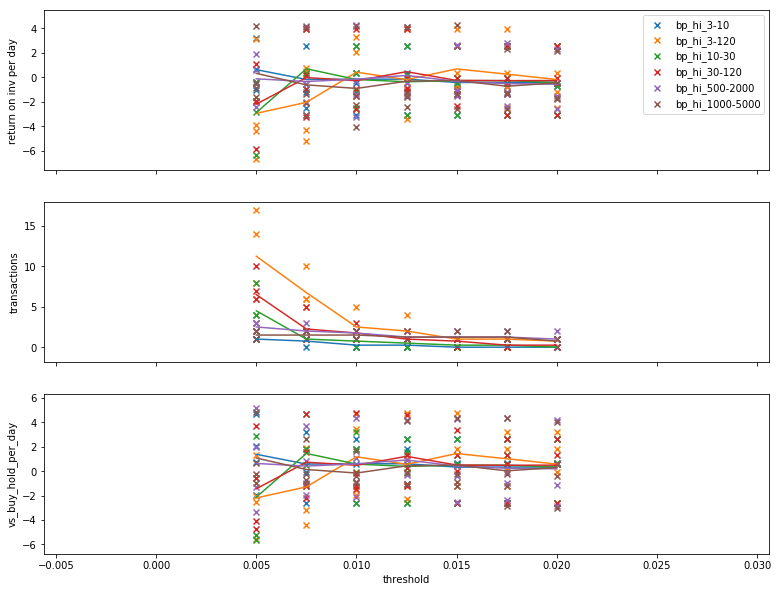

In [255]:
# test through various trend parameters

# %matplotlib notebook
# find parameters
data_all = load_data('gdax_data.csv')
data_split = split_data(data_all, 4)

thresholds = [.0025, .005, .0075, .01, .0125, .015, .0175, .02]
colnames = ['bp_hi_3-10', 'bp_hi_3-120', 'bp_hi_10-30', 'bp_hi_30-120', 'bp_hi_500-2000', 'bp_hi_1000-5000']

roi_results = {}
for colname in colnames:
    empt = {'thresholds': [], 'roi_per_day': [], 'transactions':[], 'vs_buy_hold_per_day':[]}
    roi_results[colname] = {'thresholds': [], 'roi_per_day': [], 'transactions':[], 'vs_buy_hold_per_day':[]}
    roi_results[colname]['means'] = {'thresholds': [], 'roi_per_day': [], 'transactions':[], 'vs_buy_hold_per_day':[]}
    for threshold in thresholds:
        roipd = []
        trans = []
        vsbh = []
        for data in data_split:
            df = pandize_data(data)
            df['USD'] = 0
            df.loc[0, 'USD'] = 500
            df['BTC'] = 0
            df.loc[0, 'BTC'] = .07
            strat_trend_measure(df)
            strat_trend_findbuy(df, colname=colname, threshold=threshold)
            strat_trend_findsell(df, colname=colname, threshold=threshold)
            backtest_trend(df, amount_buy=5, amount_sell=5)
            results = diagnose(df)
            roi_results[colname]['thresholds'].append(threshold)
            roi_results[colname]['roi_per_day'].append(results['roi_per_day'])
            roi_results[colname]['transactions'].append(results['transactions'])
            roi_results[colname]['vs_buy_hold_per_day'].append(results['vs_buy_hold_per_day'])
            roipd.append(results['roi_per_day'])
            trans.append(results['transactions'])
            vsbh.append(results['vs_buy_hold_per_day'])
        roi_results[colname]['means']['roi_per_day'].append(np.mean(roipd))
        roi_results[colname]['means']['transactions'].append(np.mean(trans))
        roi_results[colname]['means']['vs_buy_hold_per_day'].append(np.mean(vsbh))
    print('done col', colname)#, 'minmax', minmaxperiod)
print(roi_results)

fig, ax = plt.subplots(nrows=3, sharex=True)
# plot
for colname, results in roi_results.items():
    ax[0].scatter(np.array(results['thresholds']),
                  np.array(results['roi_per_day']),
                  label=colname, marker='x')
    ax[0].plot(thresholds,
               results['means']['roi_per_day'])
    ax[1].scatter(np.array(results['thresholds']),
                  np.array(results['transactions']),
                  label=colname, marker='x')
    ax[1].plot(thresholds,
               np.array(results['means']['transactions']))
    ax[2].scatter(np.array(results['thresholds']),
                  np.array(results['vs_buy_hold_per_day']),
                  label=colname, marker='x')
    ax[2].plot(thresholds,
               np.array(results['means']['vs_buy_hold_per_day']))
ax[0].set_ylabel('return on inv per day')
ax[0].legend()
ax[1].set_ylabel('transactions')
ax[2].set_ylabel('vs_buy_hold_per_day')
ax[2].set_xlabel('threshold')
fig.set_size_inches(13, 10)
plt.show()

done sma 1
done sma 2
done sma 3
done sma 5
done sma 10
done sma 15
done sma 20
done sma 40
done sma 60
done sma 120
[[-0.36241213261616334, -1.1685820382878909, -1.091897708591627, 0.43711021277945683, -0.7355526270782731, -0.5598946898370705, -0.6448307747640825, -0.3862655317996566, 0.11357073146891494, -1.4323459906233849, -1.876309221821626, -2.0335897376382417, -1.7056321938369812, -0.9766796961372615], [-0.36241213261616334, -1.2058033653050027, -0.1749266188926124, -1.7982145417154705, -1.552689977707833, -0.3805342359016528, -0.2553850227323906, 0.0938095150933016, 0.4063337430531444, -1.22496807310013, -1.8084661927096457, -2.050558496292565, -1.8406286706223018, -1.0306106937087334], [-0.36241213261616334, -0.8348578707824461, 0.17838723029592884, 0.9096472543183243, -0.4203320130227728, 0.648535680384632, -0.09257950575669582, 0.12085287710199566, 0.3854545690508582, -1.166455605732153, -1.862052408981163, -2.006635512423205, -1.8231549879364262, -1.0424063709652764], [-0.3

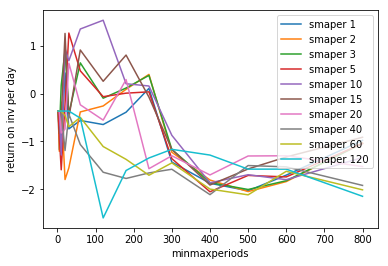

In [207]:
# test through various minmax parameters

# %matplotlib notebook
# find parameters
data = load_data('gdax_data.csv')

smaperiods = [1, 2, 3, 5, 10, 15, 20, 40, 60, 120]
minmaxperiods = [2, 5, 10, 20, 30, 60, 120, 180, 240, 300, 400, 500, 600, 800]
totally_all_res = []
# fig, ax = plt.subplots(nrows=1)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# fig.set_size_inches(15, 7)
# plt.ion()
# fig.show()
# fig.canvas.draw()
for smaperiod in smaperiods:
    all_results = []
    for minmaxperiod in minmaxperiods:
        df = pandize_data(data)
        df['USD'] = 0
        df.loc[0, 'USD'] = 500
        df['BTC'] = 0
        df.loc[0, 'BTC'] = .07
        strat_minmax_measure(df, smaperiod=smaperiod, minmaxperiod=minmaxperiod)
        strat_minmax_findbuy(df)
        strat_minmax_findsell(df)
        backtest(df, amount_buy=5, amount_sell=5)
        results = diagnose(df)
        all_results.append(results)
    print('done sma', smaperiod)#, 'minmax', minmaxperiod)
    totally_all_res.append(all_results)
#     rois = [[res['return_on_inv_perc'] for res in all_results] for all_results in totally_all_res]
#     ax.clear()
#     for currois, smaper in zip(rois, smaperiods):
#         ax.plot(minmaxperiods, currois, label='smaper {:d}'.format(smaper))
#     ax.set_xlabel('minmaxperiods')
#     ax.set_ylabel('return on inv')
#     ax.legend()
#     fig.canvas.draw()
# plt.close(fig)

fig, ax = plt.subplots(nrows=1)
# exctract
rois = [[res['roi_per_day'] for res in all_results] for all_results in totally_all_res]
print(rois)
# plot
for currois, smaper in zip(rois, smaperiods):
    ax.plot(minmaxperiods, currois, label='smaper {:d}'.format(smaper))
plt.xlabel('minmaxperiods')
plt.ylabel('return on inv per day')
ax.legend()
plt.show()


In [ ]:
# TODO: split train- and test datasets, vorlauf entsprechend periods; buget 50%50% bei anfang trading 
# TODO: always slow decay and fast rise?
# vary min/max cutoff
# trend: subtract results, calc for longer duration
# implement trend: buy > .015, sell < -.01 oder so, das + duration als parameter
# TODO: implement trading
# get and store price of transaction, compare to backtest
# import ans test json data
# fees?